# Sentiment Analysis first approach
### Word Cloud and RandomForest benchmark model

**Post:**

https://medium.com/@dilip.voleti/sentiment-analysis-using-natural-language-processing-f05b19c2a31d

**Dataset:**

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

**Visualization:**

https://towardsdev.com/how-to-use-plotly-as-pandas-plotting-backend-123ff5378003

In [1]:
#  importamos librerías

import string, re, pickle, random, datetime
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "plotly"
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report

from scikitplot.metrics import plot_confusion_matrix

#### Data Feed

----

In [2]:
# creamos el dataset de trabajo 'df'

df_train = pd.read_csv("data/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("data/val.txt",delimiter=';',names=['text','label'])

df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

print("Shape of the DataFrame:",df.shape)
df.sample(5)

Shape of the DataFrame: (18000, 2)


,text,label
4019,i often feel like a child here i speak the lan...,fear
13458,i was trying to determine why i feel so reluct...,fear
568,i feel he is sincere and repentant for his pas...,joy
15074,i am feeling a little dull this morning becaus...,sadness
7135,i still didnt see a difference in the way my p...,sadness


In [3]:
#  Discretizamos las etiquetas de forma numérica
dist_labels={}
for num,key in enumerate(list(set(df.label))):
    dist_labels[key]=num   
print(f'etiquetas: {dist_labels}')

df['label']=df['label'].map(dist_labels)
df.head()

etiquetas: {'sadness': 0, 'surprise': 1, 'love': 2, 'fear': 3, 'joy': 4, 'anger': 5}


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,5
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,5


In [4]:
"""
'labels' argument accepts a dictionary that maps column names to the new, desired labels. 
Note that the legend title can also be changed in this way because, by default, legends have the name of a column name in the dataset.
"""

df.label.value_counts().to_frame().plot(
    kind='bar',
    title='Conteo de etiquetas',
    labels={'value':'Cantidad', 'variable':'Función'},
    height=400,
    width=600,
    template='plotly_dark')



### Data Pre-processing

----

In [5]:
#  estandarizamos por lemma y eliminamos stopwords en el dataset 'corpus'

lm = WordNetLemmatizer()
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lm.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(str(x) for x in text)

corpus = df['text'].apply(lambda x:clean_text(x))

In [6]:
corpus


0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
17995    im ssa examination tomorrow morning im quite w...
17996    constantly worry fight nature push limit inner...
17997           feel important share info experience thing
17998    truly feel passionate enough something stay tr...
17999    feel like wanna buy cute make see online even one
Name: text, Length: 18000, dtype: object

### Word Cloud

----

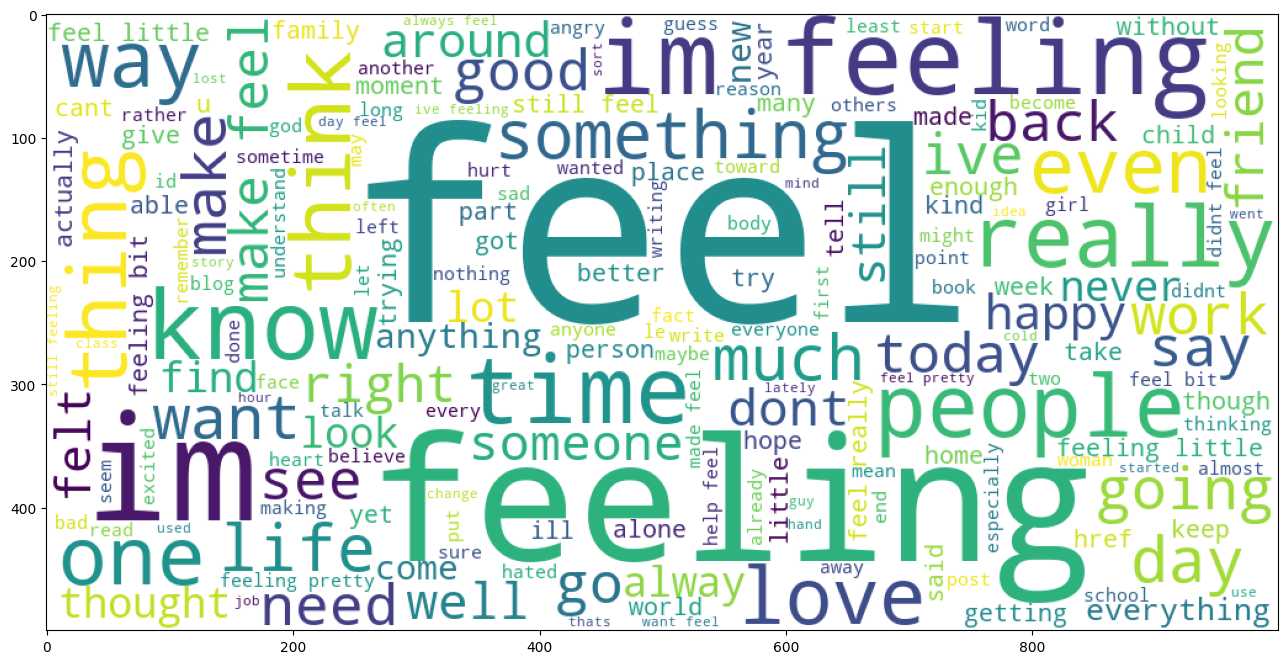

In [7]:
# Convertimos el dataset en una cadena de texto única para generar el wordcloud

plt.figure(figsize=(20,8))
word_cloud = ""
for row in corpus:
    row += " "
    word_cloud+= row

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

### Bag of Words

----

In [8]:
#  creamos la matríz de feature y el vector target

tfidf_vect = TfidfVectorizer()
x = tfidf_vect.fit_transform(corpus)
y = df.label

In [11]:
# (!) WARNING (entrenamiento)
#  Hyperameter tunning and model selection, with training

if True:

    parameters = {'max_features': ['sqrt'],
                'n_estimators': [500],
                'max_depth': [None],
                'bootstrap': [False]}

    grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
    grid_search.fit(x,y)

    #  guardamos el modelo

    file_pk = random.randint(0, 10000)
    now = datetime.datetime.now()
    file_pk = str(file_pk) +'-'+ now.strftime("%Y%m%d-%H%M%S")


    with open(f'models/01_03_grid_search_rd_{file_pk}.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
#  cargamos el modelo
if False:
    file_name = '01_03_grid_search_rd_1156-20230915-141647'

    with open(f'models/{file_name}.pkl', 'rb') as f:
        grid_search = pickle.load(f)


## Predicciones en el test set

In [12]:
trained_model = grid_search.best_estimator_
test_df = pd.read_csv('data/test.txt',delimiter=';',names=['text','label'])
X_test,y_test = test_df.text,test_df.label
#encode the labels
test_df = y_test.map(dist_labels)
#pre-processing of text
test_corpus = X_test.apply(lambda x:clean_text(x))
#convert text data into vectors
testdata = tfidf_vect.transform(test_corpus)
#predict the target
predictions = trained_model.predict(testdata)

## Evaluación de métricas

1. Accuracy Score — no. of correctly classified instances/total no. of instances

2. Precision Score — the ratio of correctly predicted instances over total positive instances

3. Recall Score — the ratio of correctly predicted instances over total instances in that class

4. Roc Curve — a plot of true positive rate against false positive rate

5. Classification Report — report of precision, recall and f1 score

6. Confusion Matrix — a table used to describe the classification models

Accuracy_score:  0.891
Precision_score:  0.891
Recall_score:  0.891
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       581
           1       0.65      0.59      0.62        66
           2       0.78      0.72      0.75       159
           3       0.86      0.88      0.87       224
           4       0.91      0.92      0.91       695
           5       0.89      0.92      0.90       275

    accuracy                           0.89      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.89      0.89      0.89      2000



<Figure size 1000x500 with 0 Axes>

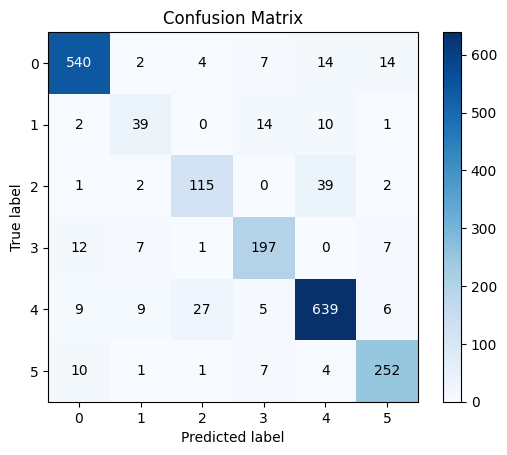

In [13]:
plt.figure(figsize=(10,5))
plot_confusion_matrix(test_df,predictions)
acc_score = accuracy_score(test_df,predictions)
pre_score = precision_score(test_df,predictions,average='micro')
rec_score = recall_score(test_df,predictions,average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_df,predictions)
print(cr)